In [49]:
# packages
import pandas as pd
import pickle
from datetime import datetime, date

In [50]:
df_sites = pickle.load(open('df_superfund_geo.pkl','rb'))

In [51]:
df_sites.head()

,Site Name,City,Site EPA ID,Listing Date,Site Score,FederalFacilityIndicator,Additional Information,Site Location,State,URL,latitude,longitude,test_index,test_url
0,Alabama Army Ammunition Plant,Childersburg,AL6210020008,07/22/1987,36.83,Yes,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,33.338100,-86.326800,0,https://epa.maps.arcgis.com/apps/webappviewer/...
1,"Alabama Plating Company, Inc.",Vincent,ALD004022448,09/18/2012,30.20,No,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,33.399722,-86.405000,1,https://epa.maps.arcgis.com/apps/webappviewer/...
2,American Brass,Headland,ALD981868466,05/10/1999,55.61,No,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,31.325000,-85.404167,2,https://epa.maps.arcgis.com/apps/webappviewer/...
3,Anniston Army Depot (Southeast Industrial Area),Anniston,AL3210020027,03/13/1989,51.91,Yes,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,33.659439,-85.969439,3,https://epa.maps.arcgis.com/apps/webappviewer/...
4,Ciba-Geigy Corp. (McIntosh Plant),McIntosh,ALD001221902,09/21/1984,53.42,No,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,31.279000,-87.995500,4,https://epa.maps.arcgis.com/apps/webappviewer/...


In [52]:
# Missing site scores
for i,x in df_sites.iterrows():
    try:
        temp = float(x['Site Score'])
    except:
        print(f'{i}[{x["Site EPA ID"]}]')

28[ARD990660649]
121[CAT080012826]
145[COD980499255]
158[CTD980521165]
162[CTD001186618]
180[DED000606079]
242[GAD099303182]
252[GUD980637649]
295[ILD000802827]
345[IND040313017]
446[MAD980731335]
462[MI0001119106]
480[MID980506281]
543[MND980609804]
566[MOD980633010]
603[MT0009083840]
645[NHD099363541]
686[NJN000206317]
727[NJD070281175]
756[NJD980755623]
777[NMD980745558]
781[NYD982531469]
800[NYD981560923]
823[NY0001233634]
840[NYD000511659]
905[OHD074727793]
952[ORN001002476]
1052[PRN000204694]
1078[RID980579056]
1103[SCD000622787]
1159[TXD980629851]
1206[VTD980523062]
1244[WAD009624453]
1297[WVD980713036]
1318[WID083290981]


In [53]:
# convert string to numeric site score
# replacing empty strings with null
list_scores = []
for i,x in df_sites.iterrows():
    try:
        list_scores.append(float(x['Site Score']))
    except:
        list_scores.append(None)
df_sites['site_score'] = list_scores

In [54]:
# only one entry option for site location
df_sites['Site Location'].unique()

array(['Site Location'], dtype=object)

In [55]:
# cancer rates are for 2012-2016. Both time the site has been active and severity of the site could play a role in cancer rates
df_sites['Listing Date'] = pd.to_datetime(df_sites['Listing Date'], infer_datetime_format=True)

In [56]:
df_sites['Listing Date'].describe()

count                    1335
unique                     79
top       1983-09-08 00:00:00
freq                      268
first     1983-09-08 00:00:00
last      2019-11-08 00:00:00
Name: Listing Date, dtype: object

If there were sites that are placed on the list after 2016 then they will not affect the cancer rates. Cancer is typically a longer-timeframe disease and as such a superfund site that started after the 2012-2016 timeline would not affect those rates.


In [57]:
print(f"{sum(df_sites['Listing Date'] > datetime(2014,7,1))} records with listing date before mid-2014")
df_sites = df_sites[df_sites['Listing Date'] <= datetime(2014,7,1)]

58 records with listing date before mid-2014


In [58]:
df_sites['site_time'] =  datetime(2014,7,1) - df_sites['Listing Date']

In [59]:
df_sites['site_time'].describe()

count                         1277
mean     8116 days 08:30:49.334377
std      3241 days 05:56:46.558929
min               50 days 00:00:00
25%             5961 days 00:00:00
50%             9036 days 00:00:00
75%            10875 days 00:00:00
max            11254 days 00:00:00
Name: site_time, dtype: object

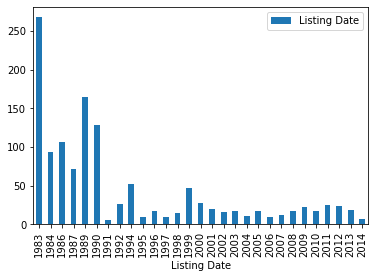

In [60]:
df_sites[["Listing Date"]].groupby(df_sites["Listing Date"].dt.year).count().plot(kind="bar")

In [61]:
df_sites['listing_year'] = df_sites["Listing Date"].dt.year

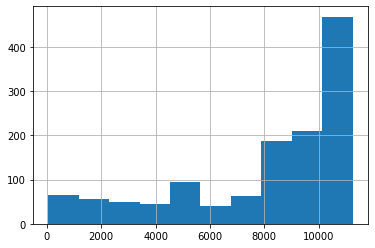

In [62]:
df_sites["site_time"].dt.days.hist()

In [63]:
def get_fips(x):

    import requests
    import urllib

    #Encode parameters 
    params = urllib.parse.urlencode({'latitude': x['latitude'], 'longitude':x['longitude'], 'format':'json'})
    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()
    return data['County']['FIPS']

In [64]:
df_sites['fips'] = df_sites[['latitude','longitude']].apply(get_fips, axis = 1)

In [65]:
df_sites['fips'].describe()

count      1277
unique      636
top       06085
freq         22
Name: fips, dtype: object

In [66]:
pickle.dump(df_sites,open('df_superfund_geo_processed.pkl','wb'))

In [48]:
df_sites['Listing Date'] = [x.date() for x in df_sites['Listing Date']]

AttributeError: 'builtin_function_or_method' object has no attribute 'date'

In [47]:
df_sites['Listing Date']

0       <built-in method date of Timestamp object at 0...
1       <built-in method date of Timestamp object at 0...
2       <built-in method date of Timestamp object at 0...
3       <built-in method date of Timestamp object at 0...
4       <built-in method date of Timestamp object at 0...
                              ...                        
1330    <built-in method date of Timestamp object at 0...
1331    <built-in method date of Timestamp object at 0...
1332    <built-in method date of Timestamp object at 0...
1333    <built-in method date of Timestamp object at 0...
1334    <built-in method date of Timestamp object at 0...
Name: Listing Date, Length: 1277, dtype: object

In [46]:
df_sites.dtypes

Site Name                            object
City                                 object
Site EPA ID                          object
Listing Date                         object
Site Score                           object
FederalFacilityIndicator             object
Additional Information               object
Site Location                        object
State                                object
URL                                  object
latitude                            float64
longitude                           float64
test_index                            int64
test_url                             object
site_score                          float64
site_time                   timedelta64[ns]
listing_year                          int64
fips                                 object
one                                   int64
dtype: object

In [42]:
import feather
df_sites
feather.write_dataframe(df_sites,'sites_data.feather')

ArrowNotImplementedError: ('Unsupported numpy type 22\n', 'Conversion failed for column site_time with type timedelta64[ns]')

In [19]:
df_sites.head()

,Site Name,City,Site EPA ID,Listing Date,Site Score,FederalFacilityIndicator,Additional Information,Site Location,State,URL,latitude,longitude,test_index,test_url,site_score,site_time,listing_year,fips
0,Alabama Army Ammunition Plant,Childersburg,AL6210020008,1987-07-22,36.83,Yes,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,33.338100,-86.326800,0,https://epa.maps.arcgis.com/apps/webappviewer/...,36.83,9841 days,1987,01121
1,"Alabama Plating Company, Inc.",Vincent,ALD004022448,2012-09-18,30.20,No,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,33.399722,-86.405000,1,https://epa.maps.arcgis.com/apps/webappviewer/...,30.20,651 days,2012,01117
2,American Brass,Headland,ALD981868466,1999-05-10,55.61,No,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,31.325000,-85.404167,2,https://epa.maps.arcgis.com/apps/webappviewer/...,55.61,5531 days,1999,01067
3,Anniston Army Depot (Southeast Industrial Area),Anniston,AL3210020027,1989-03-13,51.91,Yes,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,33.659439,-85.969439,3,https://epa.maps.arcgis.com/apps/webappviewer/...,51.91,9241 days,1989,01015
4,Ciba-Geigy Corp. (McIntosh Plant),McIntosh,ALD001221902,1984-09-21,53.42,No,Site Listing NarrativeSite Progress ProfileFed...,Site Location,Alabama,https://epa.maps.arcgis.com/apps/webappviewer/...,31.279000,-87.995500,4,https://epa.maps.arcgis.com/apps/webappviewer/...,53.42,10875 days,1984,01129


In [20]:
df_sites['one'] = 1

In [21]:
df_sites_summary = df_sites.groupby('fips')[['site_score','listing_year']].mean().reset_index().rename(columns = {'site_score' : 'avg_site_score', 'listing_year' : 'avg_listing_year'})
df_sites_summary['sum_site_score'] = df_sites.groupby('fips')['site_score'].sum().reset_index().rename(columns = {'site_score' : 'sum_site_score'})['sum_site_score']
df_sites_summary['num_sites'] = df_sites.groupby('fips')['one'].sum().reset_index().rename(columns = {'one' : 'num_sites'})['num_sites']

In [22]:
df_sites_summary.head()

,fips,avg_site_score,avg_listing_year,sum_site_score,num_sites
0,01015,51.910,1989.0,51.91,1
1,01067,55.610,1999.0,55.61,1
2,01073,42.860,1986.0,42.86,1
3,01089,50.000,1994.0,50.00,1
4,01097,39.555,1984.0,79.11,2


In [23]:
df_sites_summary.describe()

,avg_site_score,avg_listing_year,sum_site_score,num_sites
count,628.000000,636.000000,636.000000,636.000000
mean,44.080286,1992.527063,86.104717,2.007862
std,8.283998,8.214174,95.719869,2.196260
min,28.590000,1983.000000,0.000000,1.000000
25%,37.930000,1986.000000,39.972500,1.000000
50%,44.745833,1990.000000,50.000000,1.000000
75%,50.000000,1997.000000,96.775000,2.000000
max,84.910000,2014.000000,752.920000,22.000000


In [35]:
df_fips = pickle.load(open('df_fips.pkl','rb'))
df_sites_summary = df_sites_summary.merge(df_fips, how = 'outer')
df_sites_summary['num_sites'] = df_sites_summary['num_sites'].fillna(0).astype('int')

In [36]:
df_sites_summary.head()

,fips,avg_site_score,avg_listing_year,sum_site_score,num_sites,county,state
0,01015,51.910,1989.0,51.91,1,Calhoun,AL
1,01067,55.610,1999.0,55.61,1,Henry,AL
2,01073,42.860,1986.0,42.86,1,Jefferson,AL
3,01089,50.000,1994.0,50.00,1,Madison,AL
4,01097,39.555,1984.0,79.11,2,Mobile,AL


In [37]:
df_sites_summary[pd.isna(df_sites_summary['num_sites'])]

,fips,avg_site_score,avg_listing_year,sum_site_score,num_sites,county,state


In [38]:
pickle.dump(df_sites_summary,open('df_superfund_summary.pkl','wb'))